# Download Dataset

In [1]:
# Constants
NUCLEUS_API_KEY = "test_5e1c456d97854e39915291f2b809a34a"
TRAIN_SLICE_ID = "slc_cack1pp6f5ag0ahn28d0"
TEST_SLICE_ID = "slc_cacmcf9x8n7g0qjrzdh0"

DATASET_PATH = "/home/vai_voxelsafety_com/data/unsupervised_door"
DATASET_PATH = "/home/vai_voxelsafety_com/data/unsupervised_door_bloomingdale/bloomingdale-0006"

In [2]:
import nucleus
import requests
import os
from pathlib import Path

In [ ]:
def download_if_not_downloaded(slice_id):
    client = nucleus.NucleusClient(NUCLEUS_API_KEY)
    train_slice = client.get_slice(slice_id)

    raw_items = train_slice.export_raw_items()
    image_items = raw_items['raw_dataset_items']

    for item in image_items:
        metadata = item['metadata']
        response = requests.get(item['scale_url'])
        filepath = os.path.join(DATASET_PATH, metadata['split'], metadata['state'], item['ref_id'] + ".png")

        # Download if file does not exist
        if not os.path.exists(filepath):
            Path(filepath).parent.mkdir(exist_ok=True, parents=True)
            print(f"Downloading file: {filepath}")
            file = open(filepath, "wb+")
            file.write(response.content)
            file.close()
        else:
            print(f"File {filepath} exists")
    

In [ ]:
# Download train dataset
download_if_not_downloaded(TRAIN_SLICE_ID)

# Download test dataset
download_if_not_downloaded(TEST_SLICE_ID)


In [3]:
# Loading image paths
import glob
image_paths = glob.glob(DATASET_PATH + '/**/*.jpg', recursive=True)
print(image_paths)

['/home/vai_voxelsafety_com/data/unsupervised_door_bloomingdale/bloomingdale-0006/test/open/americold_savannah_bloomingdale_0006_cha_test_20220408_test_2_0000_timestamp_1400_199736_padding_30.jpg', '/home/vai_voxelsafety_com/data/unsupervised_door_bloomingdale/bloomingdale-0006/test/open/americold_savannah_bloomingdale_0006_cha_test_20220408_test_2_0000_timestamp_1000_199736_padding_60.jpg', '/home/vai_voxelsafety_com/data/unsupervised_door_bloomingdale/bloomingdale-0006/test/open/americold_savannah_bloomingdale_0006_cha_test_20220408_test_2_0000_timestamp_4400_199736_padding_30.jpg', '/home/vai_voxelsafety_com/data/unsupervised_door_bloomingdale/bloomingdale-0006/test/open/americold_savannah_bloomingdale_0006_cha_test_20220408_test_2_0000_timestamp_3400_199736_padding_60.jpg', '/home/vai_voxelsafety_com/data/unsupervised_door_bloomingdale/bloomingdale-0006/test/open/americold_savannah_bloomingdale_0006_cha_test_20220408_test_2_0000_timestamp_3200_199736_padding_0.jpg', '/home/vai_voxe

# Train Model


In [4]:
# Constants
NUM_NEIGHBORS = 5
NUM_JOBS = -1

In [5]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import argparse
import cv2
import os

In [6]:
def image_to_feature_vector(image, size=(32, 32)):
    # resize the image to a fixed size, then flatten the image into
    # a list of raw pixel intensities
    return cv2.resize(image, size).flatten()

In [7]:
def extract_color_histogram(image, bins=(8, 8, 8)):
    # extract a 3D color histogram from the HSV color space using
    # the supplied number of `bins` per channel
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, bins,
        [0, 180, 0, 256, 0, 256])
    
    # handle normalizing the histogram if we are using OpenCV 2.4.X
    hist = cv2.normalize(hist, hist)
    
    # return the flattened histogram as the feature vector
    return hist.flatten()

In [8]:
# initialize the raw pixel intensities matrix, the features matrix,
# and labels list
raw_images_train = []
features_train = []
labels_train = []

raw_images_test = []
features_test = []
labels_test = []

# loop over the input images
for (i, image_path) in enumerate(image_paths):    
    if image_path.split(os.path.sep)[-3] == 'train':
        # load the image and extract the class label (assuming that our
        # path as the format: /path/to/dataset/{class}.{image_num}.jpg
        image = cv2.imread(image_path)
        label = image_path.split(os.path.sep)[-2]

        # extract raw pixel intensity "features", followed by a color
        # histogram to characterize the color distribution of the pixels
        # in the image
        pixels = image_to_feature_vector(image)
        hist = extract_color_histogram(image)

        # update the raw images, features, and labels matricies,
        # respectively
        raw_images_train.append(pixels)
        features_train.append(hist)
        labels_train.append(label)
    
    else:
        # load the image and extract the class label (assuming that our
        # path as the format: /path/to/dataset/{class}.{image_num}.jpg
        image = cv2.imread(image_path)
        label = image_path.split(os.path.sep)[-2]

        # extract raw pixel intensity "features", followed by a color
        # histogram to characterize the color distribution of the pixels
        # in the image
        pixels = image_to_feature_vector(image)
        hist = extract_color_histogram(image)

        # update the raw images, features, and labels matricies,
        # respectively
        raw_images_test.append(pixels)
        features_test.append(hist)
        labels_test.append(label)      
    
    # show an update every 10 images
    if i > 0 and i % 10 == 0:
        print("[INFO] processed {}/{}".format(i, len(image_paths)))

[INFO] processed 10/546
[INFO] processed 20/546
[INFO] processed 30/546
[INFO] processed 40/546
[INFO] processed 50/546
[INFO] processed 60/546
[INFO] processed 70/546
[INFO] processed 80/546
[INFO] processed 90/546
[INFO] processed 100/546
[INFO] processed 110/546
[INFO] processed 120/546
[INFO] processed 130/546
[INFO] processed 140/546
[INFO] processed 150/546
[INFO] processed 160/546
[INFO] processed 170/546
[INFO] processed 180/546
[INFO] processed 190/546
[INFO] processed 200/546
[INFO] processed 210/546
[INFO] processed 220/546
[INFO] processed 230/546
[INFO] processed 240/546
[INFO] processed 250/546
[INFO] processed 260/546
[INFO] processed 270/546
[INFO] processed 280/546
[INFO] processed 290/546
[INFO] processed 300/546
[INFO] processed 310/546
[INFO] processed 320/546
[INFO] processed 330/546
[INFO] processed 340/546
[INFO] processed 350/546
[INFO] processed 360/546
[INFO] processed 370/546
[INFO] processed 380/546
[INFO] processed 390/546
[INFO] processed 400/546
[INFO] pr

In [9]:
NUM_NEIGHBORS = 2

# train and evaluate a k-NN classifer on the raw pixel intensities
model_raw = KNeighborsClassifier(n_neighbors=NUM_NEIGHBORS, n_jobs=NUM_JOBS)
model_raw.fit(raw_images_train, labels_train)
acc = model_raw.score(raw_images_test, labels_test)
print("[INFO] raw pixel accuracy: {:.2f}%".format(acc * 100))


# train and evaluate a k-NN classifer on the histogram representations
model_hist = KNeighborsClassifier(n_neighbors=NUM_NEIGHBORS, n_jobs=NUM_JOBS)
model_hist.fit(features_train, labels_train)
acc = model_hist.score(features_test, labels_test)
print("[INFO] histogram accuracy: {:.2f}%".format(acc * 100))

[INFO] raw pixel accuracy: 89.06%
[INFO] histogram accuracy: 56.25%


In [10]:
# Train / Test Split Issue?
(trainRI, testRI, trainRL, testRL) = train_test_split(raw_images_train, labels_train, test_size=0.25, random_state=42)
model_raw.fit(trainRI, trainRL)
acc = model_raw.score(testRI, testRL)
print("[INFO] raw pixel accuracy: {:.2f}%".format(acc * 100))

[INFO] raw pixel accuracy: 100.00%


# Evaluate

Classes: ['closed' 'open']
Raw: Per Class Precision [0.8372093 1.        0.       ]
Raw: Per Class Recall [1. 1. 0.]
[[108   0   0]
 [  0  63   0]
 [ 21   0   0]] ['closed' 'open']


/home/vai_voxelsafety_com/.cache/bazel/_bazel_vai_voxelsafety_com/bef16434804e5ed70ef869319509b9f7/execroot/voxel/bazel-out/k8-fastbuild/bin/third_party/jupyter/jupyter.runfiles/pip_deps_scikit_learn/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


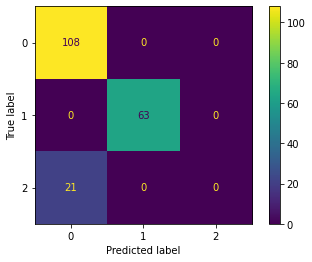

In [11]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

y_pred = model_raw.predict(raw_images_test)
print(f"Classes: {model_raw.classes_}")
print(f"Raw: Per Class Precision {precision_score(labels_test, y_pred, average=None)}")
print(f"Raw: Per Class Recall {recall_score(labels_test, y_pred, average=None)}")
cm = confusion_matrix(labels_test, y_pred)
print(cm, model_raw.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# Model Param Sweep

In [12]:
neighbors_sweep = np.linspace(1,10,10)
acc_raw = np.zeros(10)
acc_hist = np.zeros(10)

for i in range(10):
    num_neighbors = i + 1
    
    # train and evaluate a k-NN classifer on the raw pixel intensities
    model_raw = KNeighborsClassifier(n_neighbors=num_neighbors, n_jobs=NUM_JOBS)
    model_raw.fit(raw_images_train, labels_train)
    acc_raw[i] = model_raw.score(raw_images_test, labels_test)


    # train and evaluate a k-NN classifer on the histogram representations
    model_hist = KNeighborsClassifier(n_neighbors=num_neighbors, n_jobs=NUM_JOBS)
    model_hist.fit(features_train, labels_train)
    acc_hist[i] = model_hist.score(features_test, labels_test)
    

Text(0, 0.5, 'Accuracy')

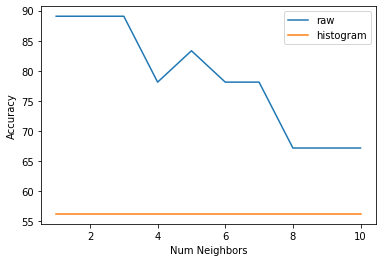

In [13]:
import matplotlib.pyplot as plt
plt.plot(neighbors_sweep, acc_raw*100, label='raw')
plt.plot(neighbors_sweep, acc_hist*100, label='histogram')
plt.legend()
plt.xlabel("Num Neighbors")
plt.ylabel("Accuracy")

# OOD

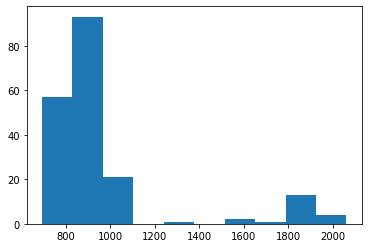

In [31]:
results = model_raw.kneighbors(raw_images_test, n_neighbors=1)
plt.hist(results[0])
plt.show()

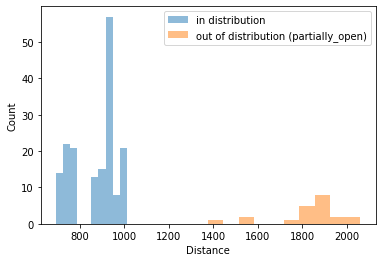

In [37]:
# Treat partially open as OOD
partially_open_indices = [i for i, x in enumerate(labels_test) if x == "partially_open"]
partially_open_raw_images_test = [raw_images_test[i] for i in partially_open_indices]

other_indices = [i for i, x in enumerate(labels_test) if x != "partially_open"]
other_raw_images_test = [raw_images_test[i] for i in other_indices]


results_ood = model_raw.kneighbors(partially_open_raw_images_test, n_neighbors=1)
results_id = model_raw.kneighbors(other_raw_images_test, n_neighbors=1)

plt.hist(results_id[0], alpha=0.5, label='in distribution')
plt.hist(results_ood[0], alpha=0.5, label='out of distribution (partially_open)')
plt.legend(loc='upper right')
plt.xlabel("Distance")
plt.ylabel("Count")
plt.show()